# Importing all libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from sklearn.linear_model import SGDClassifier
from prettytable import PrettyTable
import csv
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.calibration import CalibratedClassifierCV

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



## Reading Data

In [2]:
# https://github.com/pandas-dev/pandas/issues/11493
# https://stackoverflow.com/questions/52105659/pandas-read-csv-unexpected-end-of-data-error

project_data = pd.read_csv('train_data.csv', engine='python', error_bad_lines=False)
resource_data = pd.read_csv('resources.csv', engine='python', error_bad_lines=False)

## Combining both data frames

In [3]:
'''https://stackoverflow.com/questions/43297589/merge-two-data-
frames-based-on-common-column-values-in-pandas'''
project_data = pd.merge(project_data, resource_data, on='id')

## Preprocessing data

### Preprocessing project_submitted_datetime column

In [4]:
# https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

# https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis = 'columns', inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [5]:
# consider we have text like this "Math & Science, Warmth, Care & Hunger"
# it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
# this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
# if we have the words "The" we are going to replace it with ''(i.e removing 'The')
# we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
#" abc ".strip() will return "abc", remove the trailing spaces
# we are replacing the & value into _

def preprocess(param1):
    lst=list()
    for i in param1:
        temp=''
        for j in i.split(','):
            if 'The' in j.split():
                j=j.replace('The', '')
            j=j.replace(' ', '')
            j=j.lower()
            temp+=j.strip()+ ' '
            temp = temp.replace('&', '_')
        lst.append(temp.strip())
    return lst

### Preprocessing of project_subject_categories

In [6]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


categories = list(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocess(categories)
project_data.drop(['project_subject_categories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_categories'].values:
    cnt.update(word.split())

cat_dict = dict(cnt)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing of project_subject_subcategories

In [7]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


sub_categories = list(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocess(sub_categories)
project_data.drop(['project_subject_subcategories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_subcategories'].values:
    cnt.update(word.split())

sub_cat_dict = dict(cnt)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing teacher_prefix column

In [8]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna("")
teacher_pfx = list(project_data['teacher_prefix'].values)

teacher_pfx_list = []
for i in teacher_pfx:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace('.','')
        j = j.lower()
        temp +=j.strip()+" "
    teacher_pfx_list.append(temp.strip()) 
    
project_data['clean_teacher_prefix'] = teacher_pfx_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:kv[1]))


### Preprocessing project_grade_category column

In [9]:
prj_grd_cat = list(project_data['project_grade_category'].values)

prj_grd_cat_list = []
for i in prj_grd_cat:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j = j.replace('-','_')
        j = j.lower()
        temp +=j.strip()+" "
    prj_grd_cat_list.append(temp.strip()) 
    
project_data['clean_project_grade_category'] = prj_grd_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv:kv[1]))

### Preprocessing school_state column

In [10]:
state = list(project_data['school_state'].values)

state_list = []
for i in state:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j=j.lower()
        temp +=j.strip()+" "
        temp = temp.replace('&','')
    state_list.append(temp.strip()) 
    
project_data['clean_state'] = state_list

project_data.drop(['school_state'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv:kv[1]))

### Merging essay_(#) to essay single column

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### Preprocessing of essay column

In [14]:
preprocessed_essays = list()
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['clean_essays'] = preprocessed_essays
project_data.drop('essay', axis=1, inplace=True)

100%|██████████| 650007/650007 [21:22<00:00, 506.98it/s]   


### Computing Sentiment Scores of clean_essays

In [15]:
#import nltk
#nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg_score = list()
neu_score = list()
pos_score = list()
compound_score = list()
for essay in tqdm(project_data['clean_essays'].values):
    ss = sid.polarity_scores(essay)
    neg_score.append(ss['neg'])
    neu_score.append(ss['neu'])
    pos_score.append(ss['pos']) 
    compound_score.append(ss['compound'])   
project_data['sentiment_score_neg'] = neg_score
project_data['sentiment_score_neu'] = neu_score
project_data['sentiment_score_pos'] = pos_score
project_data['sentiment_score_compound'] = compound_score
project_data['sentiment_score_neg'] = project_data['sentiment_score_neg'].astype(float)
project_data['sentiment_score_neu'] = project_data['sentiment_score_neu'].astype(float)
project_data['sentiment_score_pos'] = project_data['sentiment_score_pos'].astype(float)
project_data['sentiment_score_compound'] = project_data['sentiment_score_compound'].astype(float)

100%|██████████| 650007/650007 [1:21:58<00:00, 132.15it/s]    


### Computing number of words in clean_essays

In [16]:
essay_length = list()
for essay in tqdm(project_data['clean_essays'].values):
    length = len(essay)
    essay_length.append(length)
project_data['clean_essay_length'] = essay_length
project_data['clean_essay_length'] = project_data['clean_essay_length'].astype(float)

100%|██████████| 650007/650007 [00:00<00:00, 1085525.21it/s]


### Preprocessing of project_title column

In [17]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent2 = decontracted(sentence)
    sent2 = sent2.replace('\\r', ' ')
    sent2 = sent2.replace('\\"', ' ')
    sent2 = sent2.replace('\\n', ' ')
    sent2 = re.sub('[^A-Za-z0-9]+', ' ', sent2)
    # https://gist.github.com/sebleier/554280
    sent2 = ' '.join(e for e in sent2.split() if e not in stopwords)
    preprocessed_titles.append(sent2.lower().strip())
    
project_data['clean_project_title'] = preprocessed_titles
project_data.drop('project_title', axis=1, inplace=True)

100%|██████████| 650007/650007 [00:21<00:00, 29828.47it/s]


### Computing number of words in clean_project_title

In [18]:
title_length = list()
for title in tqdm(project_data['clean_project_title'].values):
    length = len(title)
    title_length.append(length)
project_data['clean_title_length'] = title_length
project_data['clean_title_length'] = project_data['clean_title_length'].astype(float)

100%|██████████| 650007/650007 [00:00<00:00, 1373966.29it/s]


# Support Vector Machine

In [19]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis='columns', inplace=True)
X = project_data

## Splitting data into Train and cross validation(or test): Stratified Sampling

In [20]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## Make Data Model Ready

### Vectorizing Categorical Data

In [21]:
def categorical_vectorization(train_column, test_column):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_column)
    X_train_val_ohe = vectorizer.transform(train_column)
    X_test_val_ohe = vectorizer.transform(test_column)
    ft_name = vectorizer.get_feature_names()
    return (X_train_val_ohe, X_test_val_ohe, ft_name)

#### clean_state column

In [22]:
tra1 = X_train['clean_state'].values
tes1 = X_test['clean_state'].values
X_train_state_ohe, X_test_state_ohe, feat1 = categorical_vectorization(tra1, tes1)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(feat1)
print("="*100)

After vectorizations
(455004, 51) (455004,)
(195003, 51) (195003,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


#### clean_categories

In [23]:
tra2 = X_train['clean_categories'].values
tes2 = X_test['clean_categories'].values
X_train_clean_categories_ohe, X_test_clean_categories_ohe, feat2 = categorical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(feat2)
print("="*100)

After vectorizations
(455004, 9) (455004,)
(195003, 9) (195003,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


#### clean_subcategories 

In [24]:
tra3 = X_train['clean_subcategories'].values
tes3 = X_test['clean_subcategories'].values
X_train_clean_subcategories_ohe, X_test_clean_subcategories_ohe, feat3 = categorical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(feat3)
print("="*100)

After vectorizations
(455004, 30) (455004,)
(195003, 30) (195003,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


#### clean_project_grade_category

In [25]:
tra4 = X_train['clean_project_grade_category'].values
tes4 = X_test['clean_project_grade_category'].values
X_train_clean_project_grade_category_ohe, X_test_clean_project_grade_category_ohe, feat4 = categorical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_clean_project_grade_category_ohe.shape, y_train.shape)
print(X_test_clean_project_grade_category_ohe.shape, y_test.shape)
print(feat4)
print("="*100)

After vectorizations
(455004, 4) (455004,)
(195003, 4) (195003,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


#### clean_teacher_prefix 

In [26]:
tra5 = X_train['clean_teacher_prefix'].values
tes5 = X_test['clean_teacher_prefix'].values
X_train_clean_teacher_prefix_category_ohe, X_test_clean_teacher_prefix_category_ohe, feat5 = categorical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_clean_teacher_prefix_category_ohe.shape, y_train.shape)
print(X_test_clean_teacher_prefix_category_ohe.shape, y_test.shape)
print(feat5)
print("="*100)

After vectorizations
(455004, 5) (455004,)
(195003, 5) (195003,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### Vectorizing Numerical Data

In [27]:
def numerical_vectorization(train_column, test_column):
    normalizer = Normalizer()
    normalizer.fit(train_column)
    X_train_val_norm = normalizer.transform(train_column)
    X_test_val_norm = normalizer.transform(test_column)
    X_train_val_norm = X_train_val_norm.astype(float)
    X_test_val_norm = X_test_val_norm.astype(float)
    return (X_train_val_norm, X_test_val_norm)

#### price

In [28]:
tra6 = X_train['price'].values.reshape(-1,1)
tes6 = X_test['price'].values.reshape(-1,1)
X_train_price_norm, X_test_price_norm = numerical_vectorization(tra6, tes6)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### teacher_number_of_previously_posted_projects

In [29]:
tra7 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
tes7 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_teacher_number_of_previously_posted_projects_norm, X_test_teacher_number_of_previously_posted_projects_norm = numerical_vectorization(tra7, tes7)
print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### quantity

In [30]:
tra8 = X_train['quantity'].values.reshape(-1,1)
tes8 = X_test['quantity'].values.reshape(-1,1)
X_train_quantity_norm, X_test_quantity_norm = numerical_vectorization(tra8, tes8)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### sentiment_score_neg

In [31]:
tra9 = X_train['sentiment_score_neg'].values.reshape(-1,1)
tes9 = X_test['sentiment_score_neg'].values.reshape(-1,1)
X_train_sentiment_score_neg_norm, X_test_sentiment_score_neg_norm = numerical_vectorization(tra9, tes9)
print("After vectorizations")
print(X_train_sentiment_score_neg_norm.shape, y_train.shape)
print(X_test_sentiment_score_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### sentiment_score_neu

In [32]:
tra10 = X_train['sentiment_score_neu'].values.reshape(-1,1)
tes10 = X_test['sentiment_score_neu'].values.reshape(-1,1)
X_train_sentiment_score_neu_norm, X_test_sentiment_score_neu_norm = numerical_vectorization(tra10, tes10)
print("After vectorizations")
print(X_train_sentiment_score_neu_norm.shape, y_train.shape)
print(X_test_sentiment_score_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### sentiment_score_pos

In [33]:
tra11 = X_train['sentiment_score_pos'].values.reshape(-1,1)
tes11 = X_test['sentiment_score_pos'].values.reshape(-1,1)
X_train_sentiment_score_pos_norm, X_test_sentiment_score_pos_norm = numerical_vectorization(tra11, tes11)
print("After vectorizations")
print(X_train_sentiment_score_pos_norm.shape, y_train.shape)
print(X_test_sentiment_score_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### sentiment_score_compound

In [34]:
tra12 = X_train['sentiment_score_compound'].values.reshape(-1,1)
tes12 = X_test['sentiment_score_compound'].values.reshape(-1,1)
X_train_sentiment_score_compound_norm, X_test_sentiment_score_compound_norm = numerical_vectorization(tra12, tes12)
print("After vectorizations")
print(X_train_sentiment_score_compound_norm.shape, y_train.shape)
print(X_test_sentiment_score_compound_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### clean_title_length

In [35]:
tra13 = X_train['clean_title_length'].values.reshape(-1,1)
tes13 = X_test['clean_title_length'].values.reshape(-1,1)
X_train_clean_title_length_norm, X_test_clean_title_length_norm = numerical_vectorization(tra13, tes13)
print("After vectorizations")
print(X_train_clean_title_length_norm.shape, y_train.shape)
print(X_test_clean_title_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


#### clean_essay_length

In [36]:
tra14 = X_train['clean_essay_length'].values.reshape(-1,1)
tes14 = X_test['clean_essay_length'].values.reshape(-1,1)
X_train_clean_essay_length_norm, X_test_clean_essay_length_norm = numerical_vectorization(tra14, tes14)
print("After vectorizations")
print(X_train_clean_essay_length_norm.shape, y_train.shape)
print(X_test_clean_essay_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 1) (455004,)
(195003, 1) (195003,)


### Loading GloVe

In [37]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

## Support Vector Machine Functions

### Hyperparamters

In [38]:
parlist = [10**x for x in range(-4, 4)]
logparlist = [math.log(10**x) for x in range(-4, 4)]
parameters = {'alpha': parlist}
logparameters = {'alpha':logparlist}
print(parameters)
print(logparameters)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
{'alpha': [-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137]}


### Hyperparameter Tuning

In [39]:
# https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399

def hparameter_l1(X_tr_data, y_train_data):
    
    sgdc = SGDClassifier(loss='hinge', penalty='l1', class_weight='balanced', n_jobs=-1)
    
    clf = GridSearchCV(sgdc, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    
    train_auc = clf.cv_results_['mean_train_score']
    train_auc_std = clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std = clf.cv_results_['std_test_score']
    print("Best Hyperparameter for L1 " + str(clf.best_params_))
    print("Best score for Hyperparameter for L1 " + str(clf.best_score_))
    return (train_auc, train_auc_std, cv_auc, cv_auc_std)

In [40]:
# https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399

def hparameter_l2(X_tr_data, y_train_data):
    
    sgdc = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced', n_jobs=-1)
    
    clf = GridSearchCV(sgdc, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    
    train_auc = clf.cv_results_['mean_train_score']
    train_auc_std = clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std = clf.cv_results_['std_test_score']
    print("Best Hyperparameter for L2 " + str(clf.best_params_))
    print("Best score for Hyperparameter for L2 " + str(clf.best_score_))
    return (train_auc, train_auc_std, cv_auc, cv_auc_std)

### Plotting AUC

In [41]:
def auc_plots_l1(X_tr_data_plt, y_train_data_plt):
    train_auc_plt, train_auc_std_plt, cv_auc_plt, cv_auc_std_plt = hparameter_l1(X_tr_data_plt, y_train_data_plt)
    plt.plot(logparameters['alpha'], train_auc_plt, label='Train AUC')
    plt.gca().fill_between(logparameters['alpha'], train_auc_plt-train_auc_std_plt, \
                          train_auc_plt+train_auc_std_plt, alpha=0.2, color='darkblue')
    plt.plot(logparameters['alpha'], cv_auc_plt, label='CV AUC')
    plt.gca().fill_between(logparameters['alpha'], cv_auc_plt-cv_auc_std_plt, \
                          cv_auc_plt+cv_auc_std_plt, alpha=0.2, color='darkorange')
    plt.scatter(logparameters['alpha'], train_auc_plt, label='Train AUC points')
    plt.scatter(logparameters['alpha'], cv_auc_plt, label='CV AUC points')
    plt.legend()
    plt.xlabel("log(alpha)")
    plt.ylabel("AUC")
    plt.title("Error Plots")
    plt.grid()
    plt.show()

In [42]:
def auc_plots_l2(X_tr_data_plt, y_train_data_plt):
    train_auc_plt, train_auc_std_plt, cv_auc_plt, cv_auc_std_plt = hparameter_l2(X_tr_data_plt, y_train_data_plt)
    plt.plot(logparameters['alpha'], train_auc_plt, label='Train AUC')
    plt.gca().fill_between(logparameters['alpha'], train_auc_plt-train_auc_std_plt, \
                          train_auc_plt+train_auc_std_plt, alpha=0.2, color='darkblue')
    plt.plot(logparameters['alpha'], cv_auc_plt, label='CV AUC')
    plt.gca().fill_between(logparameters['alpha'], cv_auc_plt-cv_auc_std_plt, \
                          cv_auc_plt+cv_auc_std_plt, alpha=0.2, color='darkorange')
    plt.scatter(logparameters['alpha'], train_auc_plt, label='Train AUC points')
    plt.scatter(logparameters['alpha'], cv_auc_plt, label='CV AUC points')
    plt.legend()
    plt.xlabel("log(alpha)")
    plt.ylabel("AUC")
    plt.title("Error Plots")
    plt.grid()
    plt.show()

### Plotting ROC Curve

In [43]:
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

def roc_plots_l1(a, X_tr_data, y_train_data, X_test_data, y_test_data):
    
    sgdc = SGDClassifier(alpha=a, loss='hinge', penalty='l1', class_weight='balanced', n_jobs=-1)
    sgdc.fit(X_tr_data, y_train_data)

    calibrated = CalibratedClassifierCV(sgdc,cv=3)
    calibrated.fit( X_tr_data, y_train_data)
    
    y_train_predict = calibrated.predict_proba(X_tr_data)[:,1]
    y_test_predict = calibrated.predict_proba(X_test_data)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict)
    
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC PLOTS")
    plt.grid()
    plt.show()
    return (y_train_predict, y_test_predict)


In [44]:
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

def roc_plots_l2(a, X_tr_data, y_train_data, X_test_data, y_test_data):
    
    sgdc = SGDClassifier(alpha=a, loss='hinge', penalty='l2', class_weight='balanced', n_jobs=-1)
    sgdc.fit(X_tr_data, y_train_data)

    calibrated = CalibratedClassifierCV(sgdc,cv=3)
    calibrated.fit( X_tr_data, y_train_data)
    
    y_train_predict = calibrated.predict_proba(X_tr_data)[:,1]
    y_test_predict = calibrated.predict_proba(X_test_data)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict)
    
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
        plt.legend()
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC PLOTS")
        plt.grid()
        plt.show()
    return (y_train_predict, y_test_predict)


### Confusion Matrix of Train data

In [45]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def train_conf(y_train, y_train_predict):
    cm_train = confusion_matrix(y_train, y_train_predict.round())
    plt.title('Train actual & Train predicted Confusion matrix')
    xlabels=ylabels=['Actual', 'Predicted']
    sns.heatmap(cm_train, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

### Confusion Matrix of Test data

In [46]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def test_conf(y_test, y_test_predict):
    cm_test = confusion_matrix(y_test, y_test_predict.round())
    plt.title('Test actual & Test predicted Confusion matrix')
    xlabels=ylabels=['Actual', 'Predicted']
    sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

## Applying Support Vector Machine

### Applying Support Vector Machine on BOW,<font color='red'> SET 1</font>

### Bag of Words

In [47]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
def BOW_Vectorization(train_column, test_column):
    vectorizer_bow.fit(train_column)
    X_train_bow = vectorizer_bow.transform(train_column)
    X_test_bow = vectorizer_bow.transform(test_column)
    return (X_train_bow, X_test_bow)

#### clean_essays

In [48]:
tra15 = X_train['clean_essays'].values
tes15 = X_test['clean_essays'].values
X_train_essay_bow, X_test_essay_bow = BOW_Vectorization(tra15, tes15)
print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


#### clean_project_title

In [49]:
tra16 = X_train['clean_project_title'].values
tes16 = X_test['clean_project_title'].values
X_train_project_title_bow, X_test_project_title_bow = BOW_Vectorization(tra16, tes16)
print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


#### Combining for Set 1

In [50]:
from scipy.sparse import hstack
# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)
X_tr_bow = hstack((X_train_state_ohe, \
                   X_train_clean_categories_ohe, \
                   X_train_clean_subcategories_ohe, \
                   X_train_clean_project_grade_category_ohe, \
                   X_train_clean_teacher_prefix_category_ohe, \
                   X_train_price_norm, \
                   X_train_teacher_number_of_previously_posted_projects_norm, \
                   X_train_quantity_norm, \
                   X_train_essay_bow, \
                   X_train_project_title_bow)).tocsr()
X_test_bow = hstack((X_test_state_ohe, \
                     X_test_clean_categories_ohe, \
                     X_test_clean_subcategories_ohe, \
                     X_test_clean_project_grade_category_ohe, \
                     X_test_clean_teacher_prefix_category_ohe, \
                     X_test_price_norm, \
                     X_test_teacher_number_of_previously_posted_projects_norm, \
                     X_test_quantity_norm, \
                     X_test_essay_bow, \
                     X_test_project_title_bow)).tocsr()
print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 10102) (455004,)
(195003, 10102) (195003,)


#### Storing BOW data into pickle

In [51]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'wb') as f:
    pickle.dump([X_tr_bow, y_train, X_test_bow, y_test], f)

#### Result

#### Loading BOW data from pickle

In [52]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('bow.pickle', 'rb') as f:
    X_tr_bow, y_train, X_test_bow, y_test = pickle.load(f)

#### Plot of Train and CV AUC

Best Hyperparameter for L1 {'alpha': 0.0001}
Best score for Hyperparameter for L1 0.8081811524631575


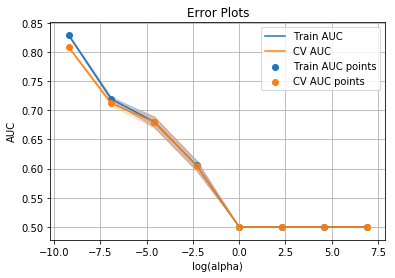

In [12]:
auc_plots_l1(X_tr_bow, y_train)

Best Hyperparameter for L2 {'alpha': 0.001}
Best score for Hyperparameter for L2 0.8578699704655447


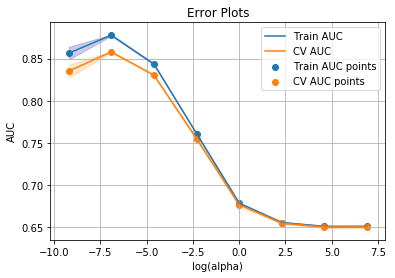

In [13]:
auc_plots_l2(X_tr_bow, y_train)

#### ROC plot on best alpha

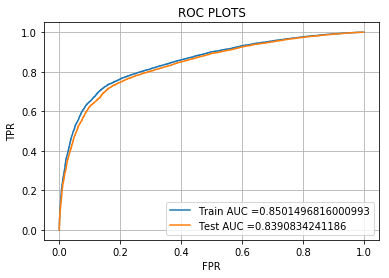

In [14]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_bow_l1, y_te_pred_bow_l1 = roc_plots_l1(0.0001, X_tr_bow, y_train, X_test_bow, y_test)

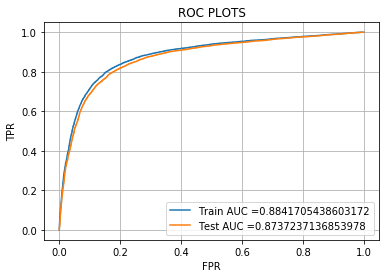

In [15]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_bow_l2, y_te_pred_bow_l2 = roc_plots_l2(0.001, X_tr_bow, y_train, X_test_bow, y_test)

#### Confusion Matrices

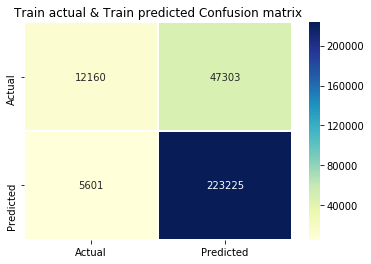

In [16]:
train_conf(y_train, y_tr_pred_bow_l1)

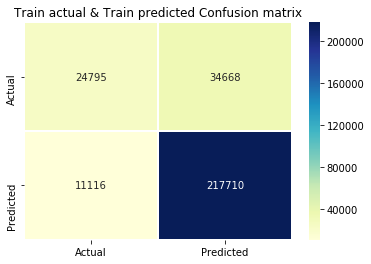

In [17]:
train_conf(y_train, y_tr_pred_bow_l2)

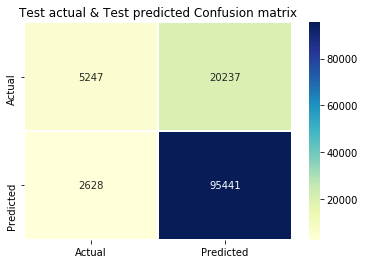

In [18]:
test_conf(y_test, y_te_pred_bow_l1)

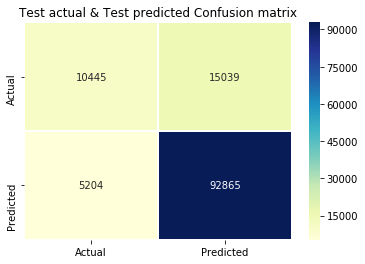

In [19]:
test_conf(y_test, y_te_pred_bow_l2)

### Applying Support Vector Machine on TFIDF,<font color='red'> SET 2</font>

### TFIDF

In [47]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)
def TFIDF_Vectorization(train_column, test_column):
    vectorizer_tfidf.fit(train_column)
    X_train_tfidf = vectorizer_tfidf.transform(train_column)
    X_test_tfidf = vectorizer_tfidf.transform(test_column)
    return (X_train_tfidf, X_test_tfidf)

#### clean_essays

In [48]:
tra17 = X_train['clean_essays'].values
tes17 = X_test['clean_essays'].values
X_train_clean_essays_tfidf, X_test_clean_essays_tfidf = TFIDF_Vectorization(tra17, tes17)
print("After vectorizations")
print(X_train_clean_essays_tfidf.shape, y_train.shape)
print(X_test_clean_essays_tfidf.shape, y_test.shape) 
print("="*100)

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


#### clean_project_title

In [61]:
tra18 = X_train['clean_project_title'].values
tes18 = X_test['clean_project_title'].values
X_train_clean_project_title_tfidf, X_test_clean_project_title_tfidf = TFIDF_Vectorization(tra18, tes18)
print("After vectorizations")
print(X_train_clean_project_title_tfidf.shape, y_train.shape)
print(X_test_clean_project_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(455004, 5000) (455004,)
(195003, 5000) (195003,)


#### Combining for Set 2

In [62]:
from scipy.sparse import hstack
# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF)
X_tr_tfidf = hstack((X_train_state_ohe, \
                     X_train_clean_categories_ohe, \
                     X_train_clean_subcategories_ohe, \
                     X_train_clean_project_grade_category_ohe, \
                     X_train_clean_teacher_prefix_category_ohe, \
                     X_train_price_norm, \
                     X_train_teacher_number_of_previously_posted_projects_norm, \
                     X_train_quantity_norm, \
                     X_train_clean_essays_tfidf, \
                     X_train_clean_project_title_tfidf)).tocsr()
X_test_tfidf = hstack((X_test_state_ohe, \
                       X_test_clean_categories_ohe, \
                       X_test_clean_subcategories_ohe, \
                       X_test_clean_project_grade_category_ohe, \
                       X_test_clean_teacher_prefix_category_ohe, \
                       X_test_price_norm, \
                       X_test_teacher_number_of_previously_posted_projects_norm, \
                       X_test_quantity_norm, \
                       X_test_clean_essays_tfidf, \
                       X_test_clean_project_title_tfidf)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 10102) (455004,)
(195003, 10102) (195003,)


#### Storing TFIDF data into pickle

In [63]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf, y_train, X_test_tfidf, y_test], f)

#### Result

#### Loading TFIDF data from pickle

In [64]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf.pickle', 'rb') as f:
    X_tr_tfidf, y_train, X_test_tfidf, y_test = pickle.load(f)

#### Plot of Train and CV AUC 

Best Hyperparameter for L1 {'alpha': 0.0001}
Best score for Hyperparameter for L1 0.7993672651279368


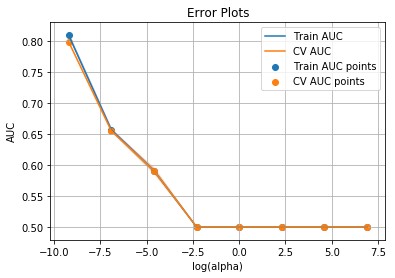

In [12]:
auc_plots_l1(X_tr_tfidf, y_train)

Best Hyperparameter for L2 {'alpha': 0.0001}
Best score for Hyperparameter for L2 0.8613660333178212


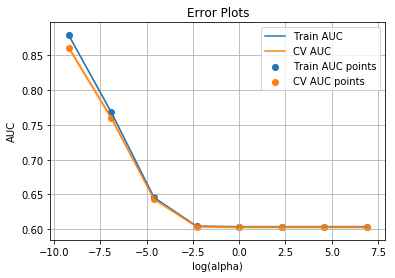

In [13]:
auc_plots_l2(X_tr_tfidf, y_train)

#### ROC plot on best alpha

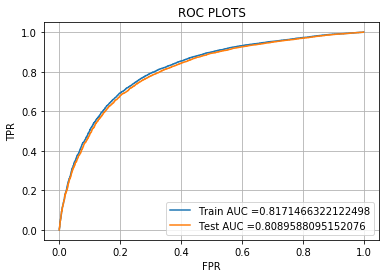

In [14]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_tfidf_l1, y_te_pred_tfidf_l1 = roc_plots_l1(0.0001, X_tr_tfidf, y_train, X_test_tfidf, y_test)

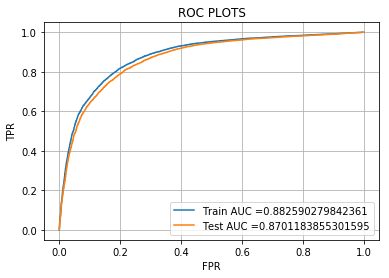

In [15]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_tfidf_l2, y_te_pred_tfidf_l2 = roc_plots_l2(0.0001, X_tr_tfidf, y_train, X_test_tfidf, y_test)

#### Confusion Matrices

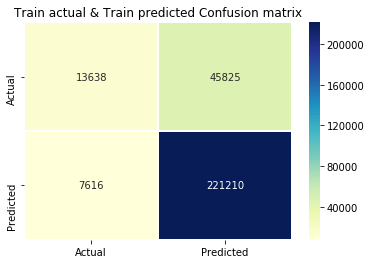

In [16]:
train_conf(y_train, y_tr_pred_tfidf_l1)

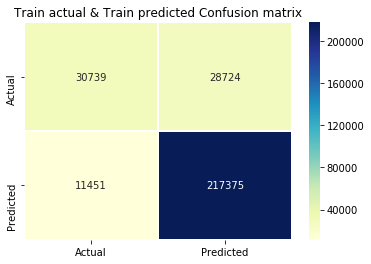

In [17]:
train_conf(y_train, y_tr_pred_tfidf_l2)

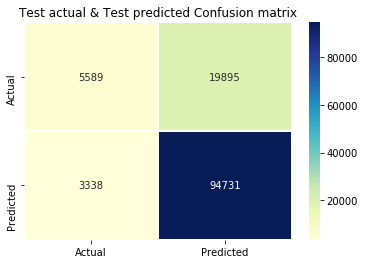

In [18]:
test_conf(y_test, y_te_pred_tfidf_l1)

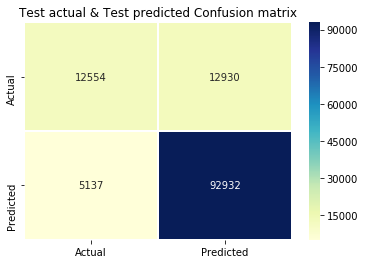

In [19]:
test_conf(y_test, y_te_pred_tfidf_l2)

### Applying Support Vector Machine on Avg W2V,<font color='red'> SET 3</font>

### Avg W2V

In [51]:
def avgw2v_vectorization(column):
    avg_w2v_train_vectors = list()
    
    for sentence in tqdm(column):
        vector = np.zeros(300)
        cnt_words =0
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_train_vectors.append(vector)
    return avg_w2v_train_vectors

#### clean_essays (Train)

In [52]:
tra19 = X_train['clean_essays'].values
avg_w2v_train_vectors_essays = avgw2v_vectorization(tra19)    

print(len(avg_w2v_train_vectors_essays))
print(len(avg_w2v_train_vectors_essays[0]))

100%|██████████| 455004/455004 [02:48<00:00, 2705.48it/s]

455004
300


#### clean_essays (Test)

In [53]:
tes19 = X_test['clean_essays'].values
avg_w2v_test_vectors_essays = avgw2v_vectorization(tes19)

print(len(avg_w2v_test_vectors_essays))
print(len(avg_w2v_test_vectors_essays[0]))

100%|██████████| 195003/195003 [01:14<00:00, 2630.09it/s]

195003
300


#### clean_project_title (Train)

In [54]:
tra20 = X_train['clean_project_title'].values
avg_w2v_train_vectors_titles = avgw2v_vectorization(tra20)    

print(len(avg_w2v_train_vectors_titles))
print(len(avg_w2v_train_vectors_titles[0]))

100%|██████████| 455004/455004 [00:14<00:00, 31229.85it/s]

455004
300


#### clean_project_title (Test)

In [55]:
tes20 = X_test['clean_project_title'].values
avg_w2v_test_vectors_titles = avgw2v_vectorization(tes20)

print(len(avg_w2v_test_vectors_titles))
print(len(avg_w2v_test_vectors_titles[0]))

100%|██████████| 195003/195003 [00:06<00:00, 29833.08it/s]

195003
300


#### Combining for Set 3

In [63]:
from scipy.sparse import hstack
# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)
X_tr_avgw2v = hstack((X_train_state_ohe, \
                      X_train_clean_categories_ohe, \
                      X_train_clean_subcategories_ohe, \
                      X_train_clean_project_grade_category_ohe, \
                      X_train_clean_teacher_prefix_category_ohe, \
                      X_train_price_norm, \
                      X_train_teacher_number_of_previously_posted_projects_norm, \
                      X_train_quantity_norm, \
                      avg_w2v_train_vectors_essays, \
                      avg_w2v_train_vectors_titles)).tocsr()
X_test_avgw2v = hstack((X_test_state_ohe, \
                        X_test_clean_categories_ohe, \
                        X_test_clean_subcategories_ohe, \
                        X_test_clean_project_grade_category_ohe, \
                        X_test_clean_teacher_prefix_category_ohe, \
                        X_test_price_norm, \
                        X_test_teacher_number_of_previously_posted_projects_norm, \
                        X_test_quantity_norm, \
                        avg_w2v_test_vectors_essays, \
                        avg_w2v_test_vectors_titles)).tocsr()
print("Final Data matrix")
print(X_tr_avgw2v.shape, y_train.shape)
print(X_test_avgw2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 702) (455004,)
(195003, 702) (195003,)


#### Storing AVG Word2Vec data into pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'wb') as f:
    pickle.dump([X_tr_avgw2v, y_train, X_test_avgw2v, y_test], f)

#### Result

#### Loading AVG Word2Vec data from pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('avgword2vec.pickle', 'rb') as f:
    X_tr_avgw2v, y_train, X_test_avgw2v, y_test = pickle.load(f)

#### Plot of Train and CV AUC 

Best Hyperparameter for L1 {'alpha': 0.0001}
Best score for Hyperparameter for L1 0.7341159929126566


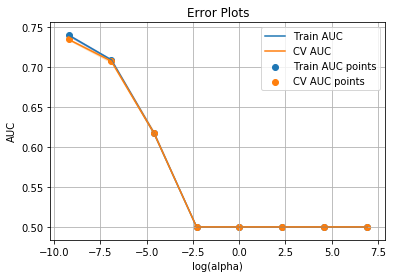

In [12]:
auc_plots_l1(X_tr_avgw2v, y_train)

Best Hyperparameter for L2 {'alpha': 0.001}
Best score for Hyperparameter for L2 0.728267394607532


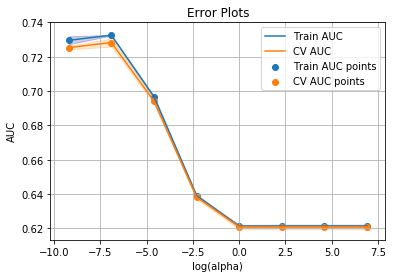

In [13]:
auc_plots_l2(X_tr_avgw2v, y_train)

#### ROC plot on best alpha

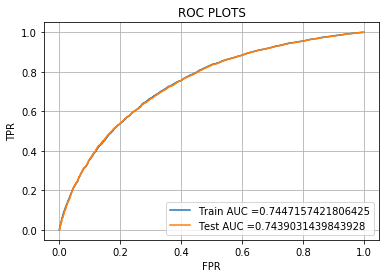

In [14]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_avgw2v_l1, y_te_pred_avgw2v_l1 = roc_plots_l1(0.0001, X_tr_avgw2v, y_train, X_test_avgw2v, y_test)

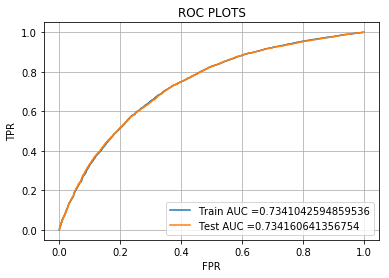

In [15]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_avgw2v_l2, y_te_pred_avgw2v_l2 = roc_plots_l2(0.001, X_tr_avgw2v, y_train, X_test_avgw2v, y_test)

#### Confusion Matrices

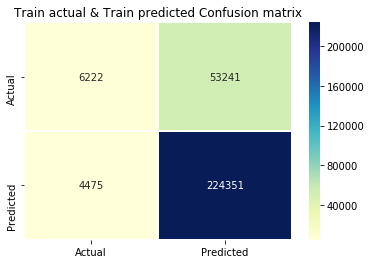

In [16]:
train_conf(y_train, y_tr_pred_avgw2v_l1)

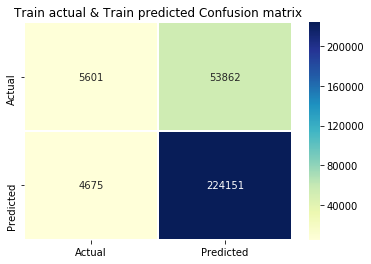

In [17]:
train_conf(y_train, y_tr_pred_avgw2v_l2)

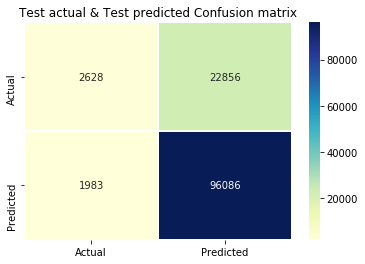

In [18]:
test_conf(y_test, y_te_pred_avgw2v_l1)

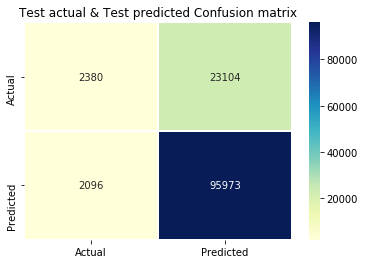

In [19]:
test_conf(y_test, y_te_pred_avgw2v_l2)

### Applying Support Vector Machine on TFIDF weighted W2V,<font color='red'> SET 4</font>

### TFIDF weighted W2V

In [ ]:
def tfidf_w_w2v_fit(column):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(column)
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return (tfidf_words, dictionary)

In [ ]:
def tfidf_w_w2v_vectorization(column):
    tfidf_words, dictionary = tfidf_w_w2v_fit(column)
    tfidf_w2v_vectors_lst = list()
    for sentence in tqdm(column):
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_lst.append(vector)
    return tfidf_w2v_vectors_lst

#### clean_essays (Train)

In [ ]:
tra21 = X_train['clean_essays'].values
tfidf_w2v_train_vectors_essays = tfidf_w_w2v_vectorization(tra21)    

print(len(tfidf_w2v_train_vectors_essays))
print(len(tfidf_w2v_train_vectors_essays[0]))

#### clean_essays (Test)

In [ ]:
tes21 = X_test['clean_essays'].values
tfidf_w2v_test_vectors_essays = tfidf_w_w2v_vectorization(tes21)

print(len(tfidf_w2v_test_vectors_essays))
print(len(tfidf_w2v_test_vectors_essays[0]))

#### clean_project_title (Train)

In [ ]:
tra22 = X_train['clean_project_title'].values
tfidf_w2v_train_vectors_titles = tfidf_w_w2v_vectorization(tra22)    

print(len(tfidf_w2v_train_vectors_titles))
print(len(tfidf_w2v_train_vectors_titles[0]))

#### clean_project_title (Test)

In [ ]:
tes22 = X_test['clean_project_title'].values
tfidf_w2v_test_vectors_titles = tfidf_w_w2v_vectorization(tes22)

print(len(tfidf_w2v_test_vectors_titles))
print(len(tfidf_w2v_test_vectors_titles[0]))

#### Combining for Set 4

In [ ]:
from scipy.sparse import hstack
# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)
X_tr_tfidf_w2v = hstack((X_train_state_ohe, \
                         X_train_clean_categories_ohe, \
                         X_train_clean_subcategories_ohe, \
                         X_train_clean_project_grade_category_ohe, \
                         X_train_clean_teacher_prefix_category_ohe, \
                         X_train_price_norm, \
                         X_train_teacher_number_of_previously_posted_projects_norm, \
                         X_train_quantity_norm, \
                         tfidf_w2v_train_vectors_essays, \
                         tfidf_w2v_train_vectors_titles)).tocsr()
X_test_tfidf_w2v = hstack((X_test_state_ohe, \
                           X_test_clean_categories_ohe, \
                           X_test_clean_subcategories_ohe, \
                           X_test_clean_project_grade_category_ohe, \
                           X_test_clean_teacher_prefix_category_ohe, \
                           X_test_price_norm, \
                           X_test_teacher_number_of_previously_posted_projects_norm, \
                           X_test_quantity_norm, \
                           tfidf_w2v_test_vectors_essays, \
                           tfidf_w2v_test_vectors_titles)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

#### Storing TFIDF weighted W2V data into pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test], f)

#### Result

#### Loading TFIDF weighted W2V data from pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test = pickle.load(f)

#### Plot of Train and CV AUC 

Best Hyperparameter for L1 {'alpha': 0.0001}
Best score for Hyperparameter for L1 0.7230834825648659


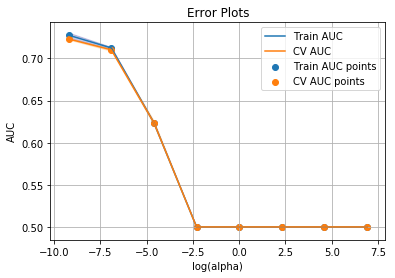

In [12]:
auc_plots_l1(X_tr_tfidf_w2v, y_train)

Best Hyperparameter for L2 {'alpha': 0.001}
Best score for Hyperparameter for L2 0.7288373208776168


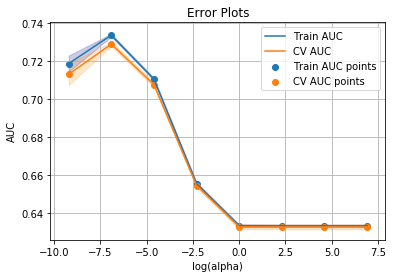

In [13]:
auc_plots_l2(X_tr_tfidf_w2v, y_train)

#### ROC plot on best alpha

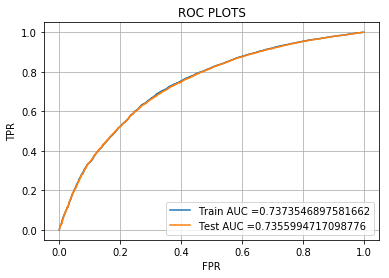

In [14]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_tfidf_w2v_l1, y_te_pred_tfidf_w2v_l1 = roc_plots_l1(0.0001, X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test)

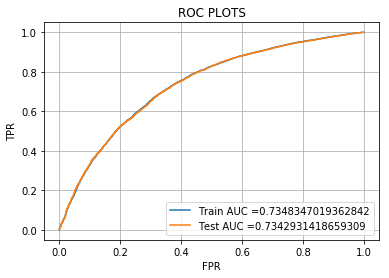

In [15]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_tfidf_w2v_l2, y_te_pred_tfidf_w2v_l2 = roc_plots_l2(0.001, X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test)

#### Confusion Matrices

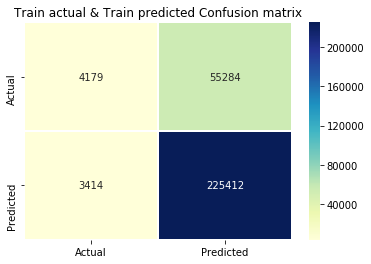

In [16]:
train_conf(y_train, y_tr_pred_tfidf_w2v_l1)

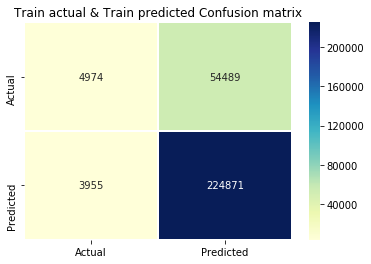

In [17]:
train_conf(y_train, y_tr_pred_tfidf_w2v_l2)

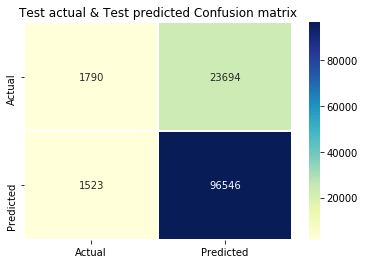

In [18]:
test_conf(y_test, y_te_pred_tfidf_w2v_l1)

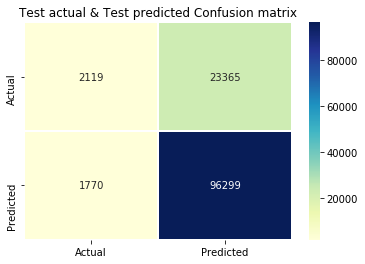

In [19]:
test_conf(y_test, y_te_pred_tfidf_w2v_l2)

### Applying Support Vector Machine on<font color='red'> SET 5</font>

#### Computing TruncatedSVD for finding n_components using elbow method

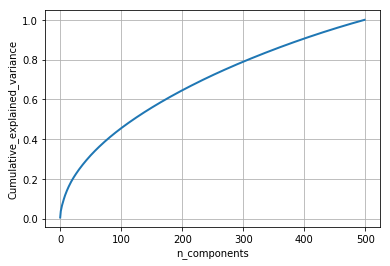

In [49]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()

svd.n_components = 500
svd.fit_transform(X_train_clean_essays_tfidf)
percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the TruncatedSVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

#### For 90% preserved features

In [51]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()

svd.n_components = 400
X_train_clean_essays_tfidf_truncatedSVD = svd.fit_transform(X_train_clean_essays_tfidf)
X_test_clean_essays_tfidf_truncatedSVD = svd.transform(X_test_clean_essays_tfidf)

#### Combining for Set 5

In [52]:
from scipy.sparse import hstack

X_tr_set5 = hstack((X_train_state_ohe, \
                    X_train_clean_categories_ohe, \
                    X_train_clean_subcategories_ohe, \
                    X_train_clean_project_grade_category_ohe, \
                    X_train_clean_teacher_prefix_category_ohe, \
                    X_train_quantity_norm, \
                    X_train_teacher_number_of_previously_posted_projects_norm, \
                    X_train_price_norm, \
                    X_train_sentiment_score_neg_norm, \
                    X_train_sentiment_score_neu_norm, \
                    X_train_sentiment_score_pos_norm, \
                    X_train_sentiment_score_compound_norm, \
                    X_train_clean_title_length_norm, \
                    X_train_clean_essay_length_norm, \
                    X_train_clean_essays_tfidf_truncatedSVD)).tocsr()
X_test_set5 = hstack((X_test_state_ohe, \
                      X_test_clean_categories_ohe, \
                      X_test_clean_subcategories_ohe, \
                      X_test_clean_project_grade_category_ohe, \
                      X_test_clean_teacher_prefix_category_ohe, \
                      X_test_quantity_norm, \
                      X_test_teacher_number_of_previously_posted_projects_norm, \
                      X_test_price_norm, \
                      X_test_sentiment_score_neg_norm, \
                      X_test_sentiment_score_neu_norm, \
                      X_test_sentiment_score_pos_norm, \
                      X_test_sentiment_score_compound_norm, \
                      X_test_clean_title_length_norm, \
                      X_test_clean_essay_length_norm, \
                      X_test_clean_essays_tfidf_truncatedSVD)).tocsr()
print("Final Data matrix")
print(X_tr_set5.shape, y_train.shape)
print(X_test_set5.shape, y_test.shape)
print("="*100)

Final Data matrix
(455004, 508) (455004,)
(195003, 508) (195003,)


#### Storing Set 5 data into pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('set5.pickle', 'wb') as f:
    pickle.dump([X_tr_set5, y_train, X_test_set5, y_test], f)

#### Loading Set 5 data from pickle

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('set5.pickle', 'rb') as f:
    X_tr_set5, y_train, X_test_set5, y_test = pickle.load(f)

#### Plot of Train and CV AUC 

Best Hyperparameter for L1 {'alpha': 0.0001}
Best score for Hyperparameter for L1 0.7427886791229951


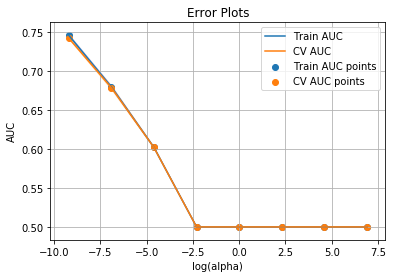

In [56]:
auc_plots_l1(X_tr_set5, y_train)

Best Hyperparameter for L2 {'alpha': 0.0001}
Best score for Hyperparameter for L2 0.7384502939483422


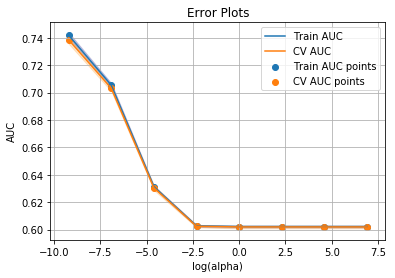

In [57]:
auc_plots_l2(X_tr_set5, y_train)

#### ROC plot on best alpha

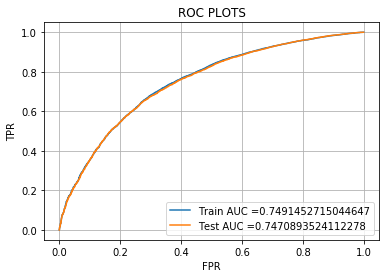

In [58]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_set5_l1, y_te_pred_set5_l1 = roc_plots_l1(0.0001, X_tr_set5, y_train, X_test_set5, y_test)

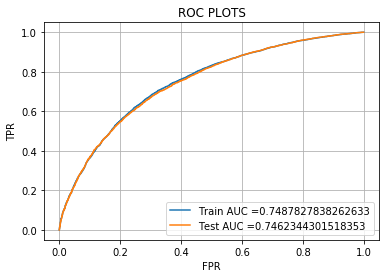

In [59]:
# {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
y_tr_pred_set5_l2, y_te_pred_set5_l2 = roc_plots_l2(0.0001, X_tr_set5, y_train, X_test_set5, y_test)

#### Confusion Matrices

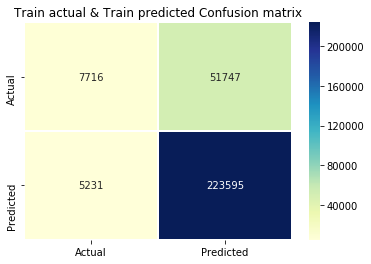

In [60]:
train_conf(y_train, y_tr_pred_set5_l1)

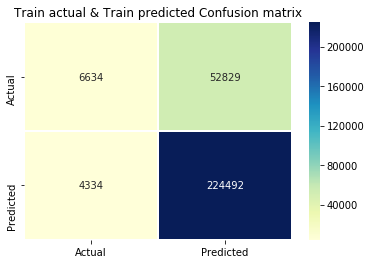

In [61]:
train_conf(y_train, y_tr_pred_set5_l2)

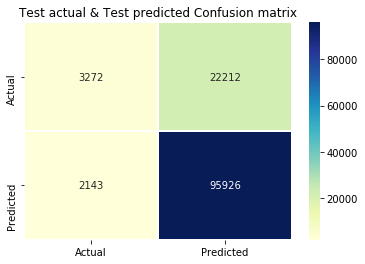

In [62]:
test_conf(y_test, y_te_pred_set5_l1)

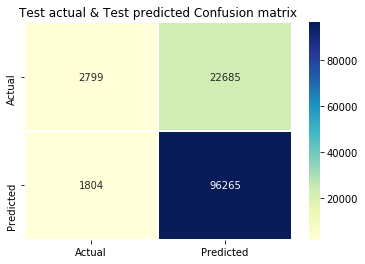

In [63]:
test_conf(y_test, y_te_pred_set5_l2)

# Conclusion

In [2]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Regularizer", "Hyperparameter-alpha", "Train AUC", "Test AUC"]
x.add_row(['BOW', 'Support Vector Machine',"L1", 0.0001, 0.8501, 0.8390])
x.add_row(['BOW', 'Support Vector Machine',"L2", 0.001, 0.8841, 0.8737])
x.add_row(['TFIDF', 'Support Vector Machine',"L1", 0.0001, 0.8171, 0.8089])
x.add_row(['TFIDF', 'Support Vector Machine',"L2", 0.0001, 0.8825, 0.8701])
x.add_row(['Avg W2V', 'Support Vector Machine',"L1", 0.0001, 0.7447, 0.7439])
x.add_row(['Avg W2V', 'Support Vector Machine',"L2", 0.001, 0.7341, 0.7341])
x.add_row(['TFIDF W2V', 'Support Vector Machine',"L1", 0.0001, 0.7373, 0.7355])
x.add_row(['TFIDF W2V', 'Support Vector Machine',"L2", 0.001, 0.7348, 0.7342])
x.add_row(['Set5', 'Support Vector Machine with TruncatedSVD',"L1", 0.0001, 0.7491, 0.7470])
x.add_row(['Set5', 'Support Vector Machine with TruncatedSVD',"L2", 0.0001, 0.7487, 0.7462])
print(x)

+------------+------------------------------------------+-------------+----------------------+-----------+----------+
| Vectorizer |                  Model                   | Regularizer | Hyperparameter-alpha | Train AUC | Test AUC |
+------------+------------------------------------------+-------------+----------------------+-----------+----------+
|    BOW     |          Support Vector Machine          |      L1     |        0.0001        |   0.8501  |  0.839   |
|    BOW     |          Support Vector Machine          |      L2     |        0.001         |   0.8841  |  0.8737  |
|   TFIDF    |          Support Vector Machine          |      L1     |        0.0001        |   0.8171  |  0.8089  |
|   TFIDF    |          Support Vector Machine          |      L2     |        0.0001        |   0.8825  |  0.8701  |
|  Avg W2V   |          Support Vector Machine          |      L1     |        0.0001        |   0.7447  |  0.7439  |
|  Avg W2V   |          Support Vector Machine          

# Summary

First I have combined both train project and resoures data. Then I have divided into train and test data in 7:3 ratio for GridSearchCV.

I have applied the following alpha to compute Support Vector Machine using both L1 & L2 regularization.

For L1 regularizer:
1. Bag of Words, Hyperparameter turned out to be 0.0001, Train AUC as 0.8501 and Test AUC as 0.839.
2. TFIDF, Hyperparameter turned out to be 0.0001, Train AUC as 0.8171 and Test AUC as 0.8089.
3. Avg W2V, Hyperparameter turned out to be 0.0001, Train AUC as 0.7447 and Test AUC as 0.7439.
4. TFIDF W2V, Hyperparameter turned out to be 0.0001, Train AUC as 0.7373 and Test AUC as 0.7355.
5. Set 5, Hyperparameter turned out to be 0.0001, Train AUC as 0.7491 and Test AUC as 0.747.

For L2 regularizer:
1. Bag of Words, Hyperparameter turned out to be 0.001, Train AUC as 0.8841 and Test AUC as 0.8737.
2. TFIDF, Hyperparameter turned out to be 0.0001, Train AUC as 0.8825 and Test AUC as 0.8701.
3. Avg W2V, Hyperparameter turned out to be 0.001, Train AUC as 0.7341 and Test AUC as 0.7341.
4. TFIDF W2V, Hyperparameter turned out to be 0.001, Train AUC as 0.7348 and Test AUC as 0.7342.
5. Set 5, Hyperparameter turned out to be 0.0001, Train AUC as 0.7487 and Test AUC as 0.7462.